# Band Structure

In this tutorial, we discuss the internals of the ``band_structure`` program, used for plotting the band structure of the Hofstadter model at fixed coprime flux density $n_\phi=p/q$ for a range of momenta $\mathbf{k}=(k_x,k_y)$. The code in this notebook is equivalent to running the command ``band_structure -lat square -nphi 1 4 -topo``.

1) Import the necessary namespace libraries. Note that library imports are segregated into ``external imports`` from the Python environment and ``internal imports`` from HT.

In [1]:
# --- external imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from prettytable import PrettyTable
from tqdm import tqdm
# --- internal imports
from HT.functions import band_structure as fbs
from HT.models.hofstadter import Hofstadter

2) Read in the inputs for the program. On the command line, these arguments are parsed from the input flags. For this notebook, however, we hard-code a minimal set of input values.

In [2]:
model = Hofstadter(1, 4, lat="square")  # the model definition
samp = 101  # number of samples (the momentum-space resolution)
bgt = 0.01  # band gap threshold (the energy scale to determine a gap)
show_band = show_group = show_isolated = show_width = show_gap = show_gap_width = True  # show basic columns
show_std_B = show_C = True  # show topology columns
show_std_g = show_av_gxx = show_std_gxx = show_av_gxy = show_std_gxy = show_T = show_D = False  # do not show quantum geometry columns

3) Define the unit cell.

In [3]:
num_bands, avec, abasisvec, bMUCvec, sym_points = model.unit_cell()

4) Construct the bands.

In [4]:
eigenvalues = np.zeros((num_bands, samp, samp))  # real
eigenvectors = np.zeros((num_bands, num_bands, samp, samp), dtype=np.complex128)  # complex
for band in tqdm(range(num_bands), desc="Band Construction", ascii=True):
    for idx_x in range(samp):
        frac_kx = idx_x / (samp-1)
        for idx_y in range(samp):
            frac_ky = idx_y / (samp-1)
            k = np.matmul(np.array([frac_kx, frac_ky]), bMUCvec)
            eigvals, eigvecs = np.linalg.eigh(model.hamiltonian(k))
            idx = np.argsort(eigvals)
            eigenvalues[band, idx_x, idx_y] = eigvals[idx[band]]
            eigenvectors[:, band, idx_x, idx_y] = eigvecs[:, idx[band]]

Band Construction: 100%|##########| 4/4 [00:03<00:00,  1.00it/s]


5) Determine the band gaps, and which bands are isolated.

In [5]:
band_gap = np.zeros(num_bands)
isolated = np.full(num_bands, True)
for band_idx, band in enumerate(np.arange(num_bands)[::-1]):
    if band_idx == 0:
        band_gap[band] = "NaN"
    else:
        band_gap[band] = np.min(eigenvalues[band + 1]) - np.max(eigenvalues[band])
    if band_gap[band] < bgt:
        isolated[band] = False
        isolated[band + 1] = False

6) Determine the band groups. Note that the band gaps are a prerequisite, and so this cannot be performed in the above loop.

In [6]:
band_group = np.zeros(num_bands, dtype=int)
band_group_val = 0
for band in range(num_bands):
    if band == 0:
        band_group[band] = 0
    elif band_gap[band - 1] > bgt:
        band_group_val = band_group_val + 1
        band_group[band] = band_group_val
    else:
        band_group[band] = band_group_val

7) Compute the band topology and geometry.

In [7]:
berry_fluxes = np.zeros((num_bands, samp-1, samp-1))  # real
for band, group in tqdm(enumerate(band_group), desc="Band Properties", ascii=True):
    group_size = np.count_nonzero(band_group == group)
    for idx_x in range(samp - 1):
        for idx_y in range(samp - 1):
            if group != band_group[band - 1]:
                berry_fluxes[band, idx_x, idx_y] = fbs.berry_curv(eigenvectors, band, idx_x, idx_y, group_size)
            else:
                berry_fluxes[band, idx_x, idx_y] = berry_fluxes[band-1, idx_x, idx_y]

Band Properties: 4it [00:01,  2.28it/s]


8) Compute the band properties of interest.

In [8]:
band_width = np.zeros(num_bands)
std_B = np.zeros(num_bands)
chern_numbers = np.zeros(num_bands)
std_g, av_gxx, std_gxx, av_gxy, std_gxy = np.zeros((5, num_bands))
av_TISM, av_DISM = np.zeros((2, num_bands))
for band_idx, band in enumerate(np.arange(num_bands)[::-1]):
    band_width[band] = np.max(eigenvalues[band]) - np.min(eigenvalues[band])
    chern_numbers[band] = np.sum(berry_fluxes[band, :, :]) / (2 * np.pi)
    std_B[band] = np.std(berry_fluxes[band, :, :])/np.abs(np.average(berry_fluxes[band, :, :]))

9) Construct the table.

In [9]:
headers = ["band", "group", "isolated", "width", "gap", "gap/width", "std_B", "C",
           "std_g", "av_gxx", "std_gxx", "av_gxy", "std_gxy", "<T>", "<D>"]
bools = [show_band, show_group, show_isolated, show_width, show_gap, show_gap_width, show_std_B, show_C,
         show_std_g, show_av_gxx, show_std_gxx, show_av_gxy, show_std_gxy, show_T, show_D]
table = PrettyTable()
name_list = []
table.field_names = [j for i, j in enumerate(headers) if bools[i]]
for band in np.arange(num_bands)[::-1]:
    data = [band, band_group[band], isolated[band], band_width[band], band_gap[band], band_gap[band]/band_width[band],
            std_B[band], round(chern_numbers[band]), 
            std_g[band], av_gxx[band], std_gxx[band], av_gxy[band], std_gxy[band], av_TISM[band], av_DISM[band]]
    table.add_row([j for i, j in enumerate(data) if bools[i]])
print(table)

+------+-------+----------+---------------------+-------------------------+------------------------+---------------------+----+
| band | group | isolated |        width        |           gap           |       gap/width        |        std_B        | C  |
+------+-------+----------+---------------------+-------------------------+------------------------+---------------------+----+
|  3   |   2   |   True   |  0.214768075399157  |           nan           |          nan           |  0.4341502309703411 | 1  |
|  2   |   1   |  False   |  1.0811042381594664 |    1.532554811187567    |   1.4175828353024273   | 0.43413492371213536 | -2 |
|  1   |   1   |  False   |  1.0811042381594662 | -1.7457315253693473e-16 | -1.614767072175557e-16 | 0.43413492371213536 | -2 |
|  0   |   0   |   True   | 0.21476807539915743 |    1.532554811187567    |   7.135859500250378    |  0.4341502309703412 | 1  |
+------+-------+----------+---------------------+-------------------------+------------------------+----

10) Construct the figure.

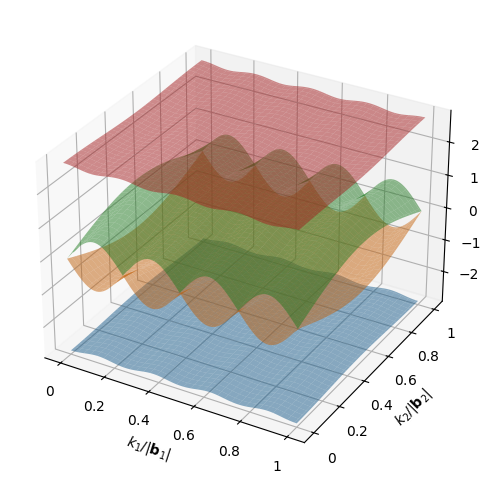

In [10]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
idx_x = np.linspace(0, samp-1, samp, dtype=int)
idx_y = np.linspace(0, samp-1, samp, dtype=int)
kx, ky = np.meshgrid(idx_x, idx_y)
for i in range(num_bands):
    ax.plot_surface(kx, ky, eigenvalues[i, kx, ky], alpha=0.5)
ax.set_xlabel('$k_1/|\mathbf{b}_1|$')
ax.set_ylabel('$k_2/|\mathbf{b}_2|$')
ax.set_zlabel('$E$')

def normalize(value, tick_number):

    if value == 0:
        return "$0$"
    elif value == samp-1:
        return "$1$"
    else:
        return f"${value / (samp-1):.1g}$"

ax.xaxis.set_major_formatter(plt.FuncFormatter(normalize))
ax.yaxis.set_major_formatter(plt.FuncFormatter(normalize))

That's it! You have successfully plotted the band structure for the Hofstadter model with a flux density of $n_\phi=1/4$. Now, we can pause to comment on how the results are presented. First, we note that the bands are numbered from 0 to 3, where 0 is the lowest band. Although this is intuitive when discussing band structures, be aware that eigenvalues in ``numpy`` are typically given in descending order. Second, we can see that the groups of touching bands have been used to compute the Chern numbers. In this case, bands 1 and 2 are touching within the ``band_gap_threshold`` and have a joint Chern number of -2. Note that the band groups provide more information than the ``isolated`` column. For example, if all bands were touching in pairs, the isolated column would read all ``False``, which is indistinguishable from the case of all bands touching. Finally, we note that in the case of band touching, certain properties that are applicable to the collective band, e.g. the bandwidth, are repeated on both rows. The value in each of these rows corresponds to the value for the band group. Moreover, the band gap column shows the gap to the band above and so is N/A for the highest band.